In [1]:
import pandas as pd
import matplotlib.axes as ax
%matplotlib inline
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

## Executive Summary

Military coups have existed since as far as 800 BC. They occur when an illegitimate claimant to power within a state for at least seven days. Although coups have been fewer in recent time, there have been about 460 coup attempts since 1950 (of which roughly 50% were successful). In past century, coups have been mostly common in Africa and the Americas, with fewer coups occurring Europe. Most of the coup attempts in the past 60 years occurred in the 1960s, at the same times majority of African nations gained independece from the Europeans. However, in recent times, successful coups have been less frequent either because governments have developed new methods in containing the usurpers, or because recent coup leaders are less strategic in claiming the throne. That, however, is a data science question for another project. 

Although successful coups are more prominent, attempted coups are more frequent than one would expect. In the past 16 years alone, there have been 30 attempted coups (seven successful), with majority occurring in Africa. Many of these coup attemps did not gain as much international attention as that of Turkey that occurred July 15, 2016. The recent coups attempts causes one to wonder if there ways to predict a coup attempt (successful or not), given the social and polical climate in a state.

Problem Statement: Considering social and political instabilities that have occurred in recent times, I want predict the likelihood of a coup d'etat within a country, given specific economic, political and social factors.

- Economic factors: income per capita, growth rate
- Social factors: accounts of ethnic violence, religious, linguistic, and ethnic fractionalization, fatalities from 
  violence, urbanization
- Political factors: polity score, length of stay for incumbent head of state


Data was collected from the Center for Systemic Peace, and then parsed. For my analysis, I will be using a Random Forest Classifier model to predict the occurrence of a coup. The dataset consist of 2,996 observations and 20 variables. 
  

In [2]:
coup = pd.read_csv("../assets/csv/Coups.csv")
stab = pd.read_csv("../assets/csv/Politicalinstability2.csv")
polity = pd.read_csv("../assets/csv/polity.csv")
leaders = pd.read_csv("../assets/csv/leaders.csv")
urban = pd.read_csv("../assets/csv/urbanpop.csv")
gdp = pd.read_csv("../assets/csv/Realpercapitagdp.csv")
growth = pd.read_csv("../assets/csv/GDPgrowth.csv")

In [3]:
#coup.head()

In [4]:
# Summing scoup1(successful coups) and acoup1(attempted coups) to generate sumcoup
# I want a columns with binary variables that indicates coup (successful and attempted) or no coup
coup["sumcoup"] = coup["scoup1"] + coup["atcoup2"]

# To make a bianary column
coupbin = []
for i in coup["sumcoup"].tolist():
    if i > 0:
        coupbin.append(1)
    if i == 0:
        coupbin.append(0)
coup["Coup"] = coupbin

In [5]:
# Dropping unnecessary columns
coup.drop(["scoup1", "atcoup2", "sumcoup"], axis=1, inplace=True)

In [6]:
coup.head()

,country,year,Coup
0,Afghanistan,1955,0
1,Afghanistan,1956,0
2,Afghanistan,1957,0
3,Afghanistan,1958,0
4,Afghanistan,1959,0


In [7]:
# coup.head()

In [8]:
# To covert the variables in PTYPE to dummy variables 
dummies = pd.get_dummies(stab["PTYPE"])
stab = stab[["COUNTRY", "YEAR", "GENDEATHMAG", "ETHMAGFATAL", 
             "ETHMAGFIGHT", "REVMAGFATAL", "REVMAGFIGHT"]].join(dummies)

stab.columns = ["COUNTRY", "YEAR", "GENDEATHMAG", "ETHMAGFATAL", 
                "ETHMAGFIGHT", "REVMAGFATAL", "REVMAGFIGHT", "NONE",
                "ETH", "REV", "GEN"]

In [9]:
# To avoid repetition of rows, I want to group the dataframes bq
aggMap = { "NONE" : "max", "ETH" : "max", "REV" : "max", 
           "GEN" : "max", "GENDEATHMAG" : "max", 
           "ETHMAGFATAL" : "max", "ETHMAGFIGHT" : "max", 
           "REVMAGFATAL" : "max", "REVMAGFIGHT" : "max" }

stabGrouped = stab.groupby(["COUNTRY","YEAR"]).agg(aggMap).reset_index()

In [10]:
#stabGrouped.head()

In [11]:
stab.head()

,COUNTRY,YEAR,GENDEATHMAG,ETHMAGFATAL,ETHMAGFIGHT,REVMAGFATAL,REVMAGFIGHT,NONE,ETH,REV,GEN
0,Afghanistan,1955,0.0,0,0,0,0,1.0,0.0,0.0,0.0
1,Afghanistan,1956,0.0,0,0,0,0,1.0,0.0,0.0,0.0
2,Afghanistan,1957,0.0,0,0,0,0,1.0,0.0,0.0,0.0
3,Afghanistan,1958,0.0,0,0,0,0,1.0,0.0,0.0,0.0
4,Afghanistan,1959,0.0,0,0,0,0,1.0,0.0,0.0,0.0


In [12]:
# Joining the political stabilty and coup tables 
coup1 = coup.merge(stabGrouped, how="inner", left_on=["country", "year"], right_on=["COUNTRY", "YEAR"])

In [13]:
# dropping the unnecessary columns and setting all columns to lower case for easier manipulation in the future
coup1.drop(["COUNTRY", "YEAR"], axis=1, inplace=True)
coup1.columns = map(str.lower, coup1.columns)

In [14]:
#coup1.head()

In [15]:
#polity.head()

In [16]:
# Dropping unnecessary variables
polity.drop(["flag", "fragment", "democ", "autoc", "polity"], axis=1, inplace=True)

In [17]:
# Merging polity table with coup1 table
coup2 = coup1.merge(polity, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [18]:
#coup2.head()

In [19]:
#leaders.head()

In [20]:
# Merging coup2 and leaders
coup3 = coup2.merge(leaders, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [21]:
#coup3.head()

In [22]:
#urban.head()

In [23]:
# I want to change the shape of the table, so the year columns become rows
Col1 = urban.columns[0]
Col2 = urban.columns[1:].tolist()
urban1 = pd.melt(urban, id_vars=(Col1), var_name="year", value_vars=(Col2), value_name="urbanpop")
urban1.sort_values(["country", "year"], inplace=True)

In [24]:
#urban1.head()

In [25]:
#gdp.head()

The gdp table shows the real per capita GDP of each country from 1969 to 2015.

In [26]:
# Also changing the shape of the table here
Col3 = gdp.columns[0]
Col4 = gdp.columns[1:].tolist()
gdp1 = pd.melt(gdp, id_vars=(Col3), var_name="year", value_vars=(Col4), value_name="gdppercap")
gdp1.sort_values(["country", "year"], inplace=True)

In [27]:
#gdp1.head()

In [28]:
# Cleaning the values in the gdp1 table
gdp1['gdppercap'] = gdp1['gdppercap'].str.replace('$', '')
gdp1['gdppercap'] = gdp1['gdppercap'].str.replace(',', '')

In [29]:
# Coverting the values to numeric
gdp1['gdppercap'] = gdp1['gdppercap'].convert_objects(convert_numeric=True)
gdp1.dtypes

/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


country       object
year          object
gdppercap    float64
dtype: object

In [30]:
#growth.head()

In [31]:
# Changing the shape of the table
Col5 = growth.columns[0]
Col6 = growth.columns[1:].tolist()
growth1 = pd.melt(growth, id_vars=(Col5), var_name="year", value_vars=(Col6), value_name="gdpgrowth")
growth1.sort_values(["country", "year"], inplace=True)

In [32]:
#growth1.head()

In [33]:
# Converting to numeric
growth1['gdpgrowth'] = growth1['gdpgrowth'].convert_objects(convert_numeric=True)
growth1.dtypes

/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


country       object
year          object
gdpgrowth    float64
dtype: object

In [34]:
# Joining tables again
Econ = gdp1.merge(growth1, how="inner", left_on=["country", "year"], right_on=["country", "year"])
Econ1 = Econ.merge(urban1, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [35]:
#Econ1.head()

In [36]:
#Econ1.dtypes

In [37]:
# Convert the year column to numeric
Econ1["year"] = Econ1["year"].convert_objects(convert_numeric=True)

/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [38]:
# Final join!
DF = Econ1.merge(coup3, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [39]:
#DF.head()

In [40]:
# Incorporating a new table into the dataframe
# Importing the csv file as a list of lists
# Converting the list to a data dictionary, with the countries being the keys and ethinic, linguistic, and religious
# fractionalization respectively serving as the values

path = "../assets/csv/diversity.csv"
import csv

def read_file(path):
    with open(path, 'r') as f:
        diversity = [row for row in csv.reader(f.read().splitlines())]
    return diversity

diversity = read_file(path)
diversity = diversity[1:]
#print diversity

def function(i):return (i[0], i[1:])
div_dict = map(function, diversity)
divDict = dict(div_dict)
#print myNewDict


In [41]:
# Matching the values from the dictionary to their respective countries

loc = DF["country"].tolist()


ethnicity = []
linguistic = []
religious = []


for i in loc:
    for country, ethnic in divDict.items():
        if i == country:
            ethnicity.append( ethnic[0] )
            linguistic.append( ethnic[1] )
            religious.append( ethnic[2] )

In [42]:
#Assigning these values to their respective columns
DF["ethnic"] = ethnicity
DF["linguistic"] = linguistic
DF["religious"] = religious

In [43]:
#DF.head()

In [44]:
DF.count()

country        3121
year           3121
gdppercap      3068
gdpgrowth      3068
urbanpop       3121
coup           3121
none           3121
revmagfight    3121
gendeathmag    3121
ethmagfatal    3121
revmagfatal    3121
eth            3121
ethmagfight    3121
rev            3121
gen            3121
polity2        3121
durable        3121
yip            3121
ethnic         3121
linguistic     3121
religious      3121
dtype: int64

In [45]:
# Drop rows with missing values (since they are relatively few)
# Drop the year columns since I won't be needing it for my analysis
DF.dropna(axis=0, how="any", inplace=True)
DF.drop(["year"], axis=1, inplace=True)

In [46]:
DF.shape

(3046, 20)

In [47]:
DF["coup"].value_counts()

0    2861
1     185
Name: coup, dtype: int64

In [48]:
# Converting year column to numeric
DF[["ethnic", "linguistic", "religious"]] = DF[["ethnic", "linguistic", "religious"]] \
                                            .convert_objects(convert_numeric=True)

/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [49]:
DF = DF[DF.ethmagfatal != 9]
DF = DF[DF.ethmagfight != 9]
DF = DF[DF.revmagfatal != 9]
DF = DF[DF.revmagfight != 9]

In [50]:
DF["ethmagfatal"].unique()

array([0, 3, 2, 4, 1])

In [51]:
DF.head()

,country,gdppercap,gdpgrowth,urbanpop,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,polity2,durable,yip,ethnic,linguistic,religious
1,Afghanistan,287.0,4.04,11.53,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,6.0,37,0.7693,0.6141,0.2717
2,Afghanistan,291.0,3.88,11.92,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,7.0,38,0.7693,0.6141,0.2717
3,Afghanistan,294.0,3.74,12.32,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,8.0,39,0.7693,0.6141,0.2717
4,Afghanistan,297.0,3.60,12.73,1,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,9.0,40,0.7693,0.6141,0.2717
5,Afghanistan,300.0,3.48,13.15,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,10.0,1,0.7693,0.6141,0.2717


In [52]:
DF.dtypes

country         object
gdppercap      float64
gdpgrowth      float64
urbanpop       float64
coup             int64
none           float64
revmagfight      int64
gendeathmag    float64
ethmagfatal      int64
revmagfatal      int64
eth            float64
ethmagfight      int64
rev            float64
gen            float64
polity2          int64
durable        float64
yip              int64
ethnic         float64
linguistic     float64
religious      float64
dtype: object

Variable|Description|Data Type|Variable Type
--|--
country|Country Name|Object|Unique
coup|1 = Coup(successful and attempted), 0 = No coup|Integer|Binary
gdppercap|GDP per capita|Float|Continuous 
gdpgrowth|GDP growth rate|Float|Continuous
urbanpop|Percentage of urban population|Float|Continuous
gendeathmag|Scaled annual number of deaths (range 0-5.0)|Float|Categorical Ordinal
revmagfight|Scaled annual number of fatalities related to revolutionary fighting (range 0-4)|Integer|Categorical Ordinal
ethmagfatal|Scaled annual number of fatalities related to ethnic fighting (range 0-4)|Integer|Categorical Ordinal
revmagfatal|Scaled number of rebel combatants or activists in revolutionary war (range 0-4)|Integer|Categorical Ordinal
ethmagfight|Scaled number of rebel combatants or activists in ethnic war (range 0-4)|Integer|Categorical Ordinal
polity2|Polity scale ranging from +10 (strongly democratic) to -10 (strongly autocratic)|Integer|Categorical Non-Ordinal
durable|Regime durabilty: the number of years since the most recent regime|Float|Categorical Ordinal
yip|Number of years head of state has been in power|Integer|Continuous
none|No violence occured|Float|Binary
eth|Indicates the occurence of an ethnic violence|Float|Binary
rev|Indicates the occurence of a revolutionary violence|Float|Binary
gen|Indicates the occurence of a genocide|Float|Binary
ethnic| Ethnic Fractionalization|Float|Continuous
linguistic|Linguistic Fractionalization|Float|Continuous
religious| Religious Fractionalization|Float|Continuous

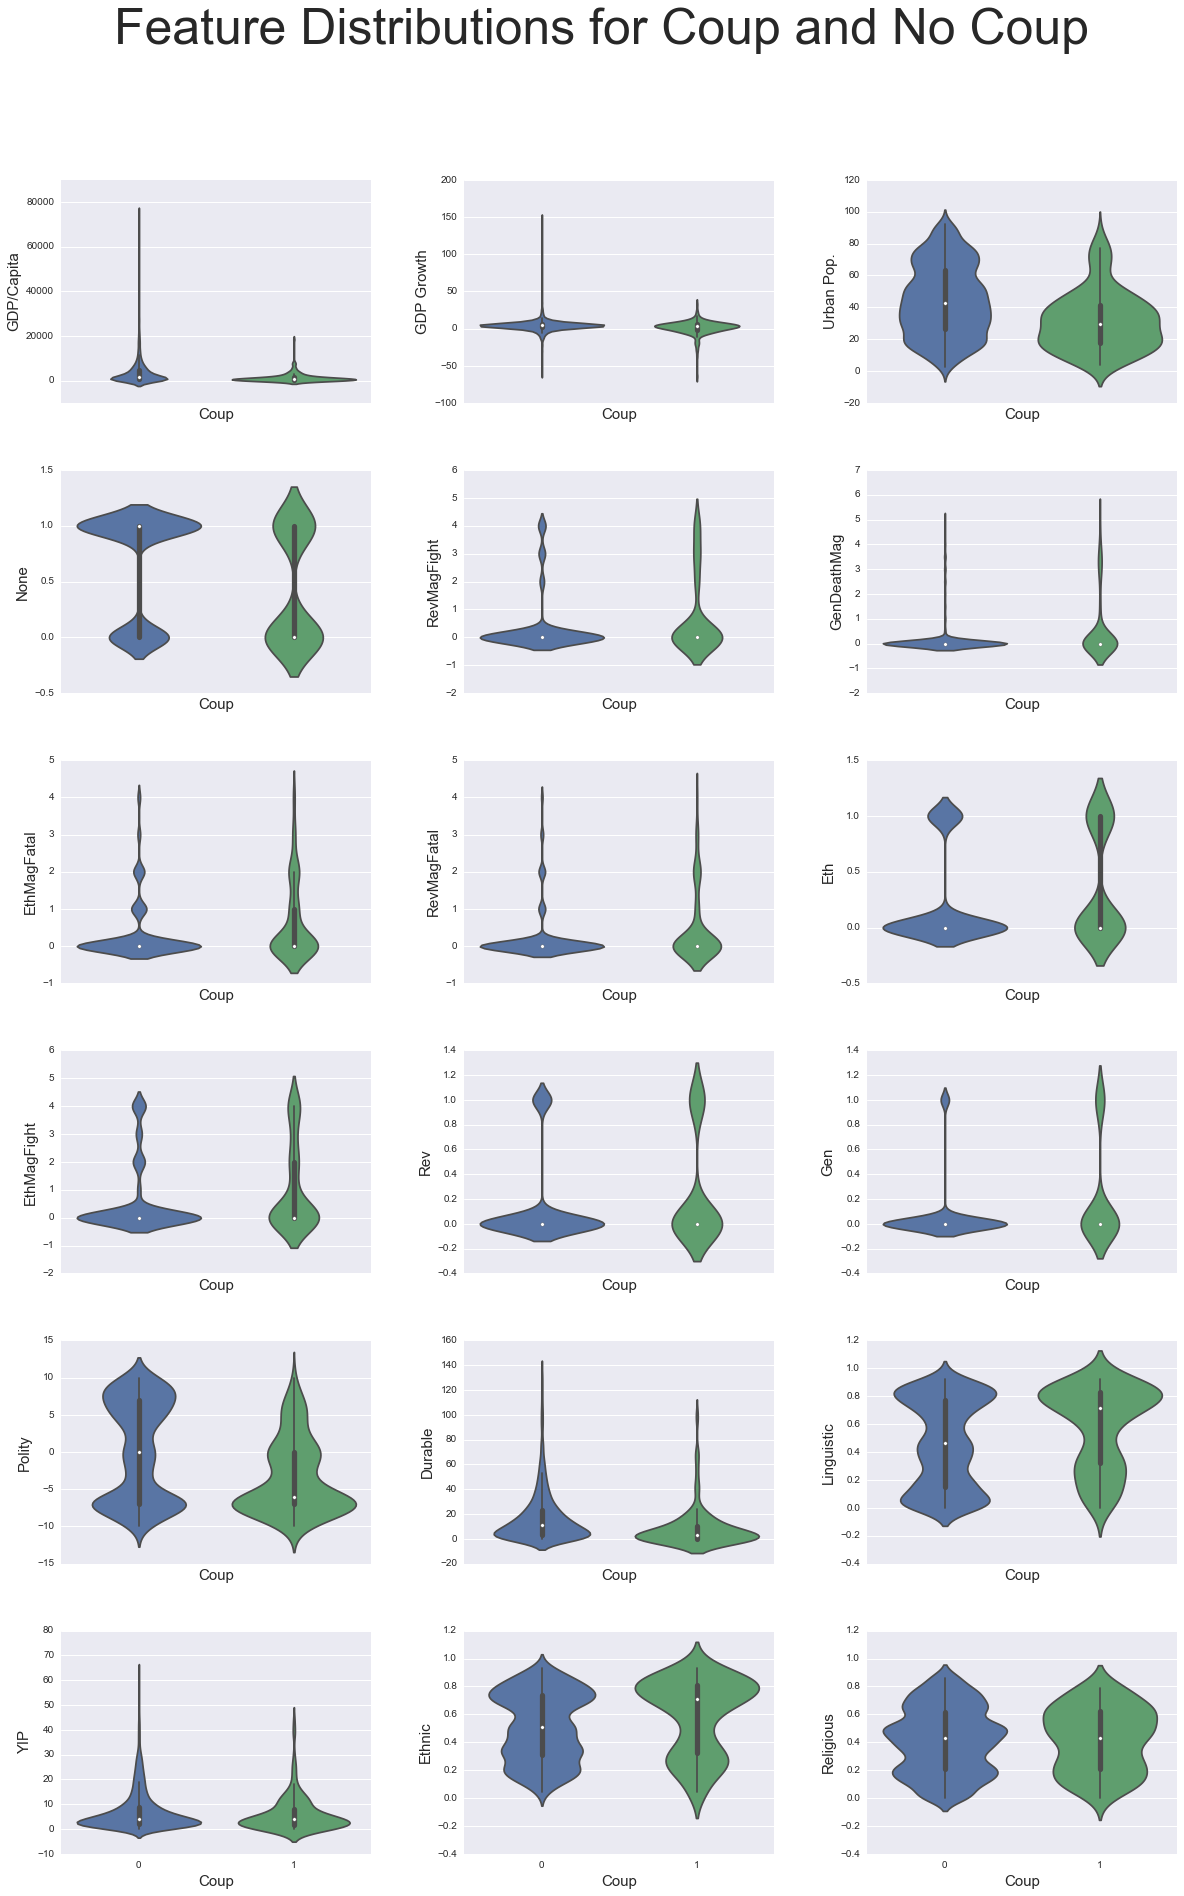

In [53]:
# To observe the differences in distribution of feactures for coup and no coup
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), \
      (ax13, ax14, ax15), (ax16, ax17, ax18)) = plt.subplots(nrows=6, ncols=3, \
        sharey=False, sharex=True, figsize=(20,30))
fig.suptitle("Feature Distributions for Coup and No Coup", size=50)

sns.set_style("whitegrid")
sns.violinplot(x='coup', y="gdppercap", data=DF, ax=ax1)
ax1.set_xlabel("Coup", fontsize=15)
ax1.set_ylabel("GDP/Capita", fontsize=15)  
    
sns.violinplot(x='coup', y="gdpgrowth", data=DF, ax=ax2)
ax2.set_xlabel("Coup", fontsize=15)
ax2.set_ylabel("GDP Growth", fontsize=15)

sns.violinplot(x='coup', y="urbanpop", data=DF, ax=ax3)
ax3.set_xlabel("Coup", fontsize=15)
ax3.set_ylabel("Urban Pop.", fontsize=15)

sns.violinplot(x='coup', y="none", data=DF, ax=ax4)
ax4.set_xlabel("Coup", fontsize=15)
ax4.set_ylabel("None", fontsize=15)

sns.violinplot(x='coup', y="revmagfight", data=DF, ax=ax5)
ax5.set_xlabel("Coup", fontsize=15)
ax5.set_ylabel("RevMagFight", fontsize=15)

sns.violinplot(x='coup', y="gendeathmag", data=DF, ax=ax6)
ax6.set_xlabel("Coup", fontsize=15)
ax6.set_ylabel("GenDeathMag", fontsize=15)

sns.violinplot(x='coup', y="ethmagfatal", data=DF, ax=ax7)
ax7.set_xlabel("Coup", fontsize=15)
ax7.set_ylabel("EthMagFatal", fontsize=15)

sns.violinplot(x='coup', y="revmagfatal", data=DF, ax=ax8)
ax8.set_xlabel("Coup", fontsize=15)
ax8.set_ylabel("RevMagFatal", fontsize=15)

sns.violinplot(x='coup', y="eth", data=DF, ax=ax9)
ax9.set_xlabel("Coup", fontsize=15)
ax9.set_ylabel("Eth", fontsize=15)

sns.violinplot(x='coup', y="ethmagfight", data=DF, ax=ax10)
ax10.set_xlabel("Coup", fontsize=15)
ax10.set_ylabel("EthMagFight", fontsize=15)

sns.violinplot(x='coup', y="rev", data=DF, ax=ax11)
ax11.set_xlabel("Coup", fontsize=15)
ax11.set_ylabel("Rev", fontsize=15)

sns.violinplot(x='coup', y="gen", data=DF, ax=ax12)
ax12.set_xlabel("Coup", fontsize=15)
ax12.set_ylabel("Gen", fontsize=15)

sns.violinplot(x='coup', y="polity2", data=DF, ax=ax13)
ax13.set_xlabel("Coup", fontsize=15)
ax13.set_ylabel("Polity", fontsize=15)

sns.violinplot(x='coup', y="durable", data=DF, ax=ax14)
ax14.set_xlabel("Coup", fontsize=15)
ax14.set_ylabel("Durable", fontsize=15)

sns.violinplot(x='coup', y="linguistic", data=DF, ax=ax15)
ax15.set_xlabel("Coup", fontsize=15)
ax15.set_ylabel("Linguistic", fontsize=15)

sns.violinplot(x='coup', y="yip", data=DF, ax=ax16)
ax16.set_xlabel("Coup", fontsize=15)
ax16.set_ylabel("YIP", fontsize=15)

sns.violinplot(x='coup', y="ethnic", data=DF, ax=ax17)
ax17.set_xlabel("Coup", fontsize=15)
ax17.set_ylabel("Ethnic", fontsize=15)

sns.violinplot(x='coup', y="religious", data=DF, ax=ax18)
ax18.set_xlabel("Coup", fontsize=15)
ax18.set_ylabel("Religious", fontsize=15)

fig.subplots_adjust(hspace=.3, wspace=.3)

In [54]:
# To split the dataframe into one with instances of a coup and another with instances of no coup
acoup = DF.loc[DF.coup==1]
nocoup = DF.loc[DF.coup==0]

In [55]:
#acoup.head()

In [56]:
#nocoup.head()

In [57]:
acoup.describe()

,gdppercap,gdpgrowth,urbanpop,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,polity2,durable,yip,ethnic,linguistic,religious
count,180.000000,180.000000,180.000000,180.0,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,1389.011111,1.361944,31.696611,1.0,0.422222,0.722222,0.513889,0.622222,0.455556,0.355556,1.016667,0.233333,0.188889,-3.483333,8.838889,6.183333,0.588908,0.582316,0.422165
std,2012.313052,9.550538,18.472209,0.0,0.495291,1.366215,1.191720,1.014727,0.923451,0.480017,1.522549,0.424132,0.392512,4.872079,16.183709,7.202944,0.266866,0.290044,0.226474
min,15.000000,-64.050000,3.650000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.000000,0.000000,0.000000,0.045400,0.000000,0.003500
25%,386.000000,-1.855000,17.362500,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,1.750000,0.320000,0.322000,0.209000
50%,582.500000,3.010000,29.630000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,3.000000,4.000000,0.709800,0.719000,0.430850
75%,1482.250000,5.630000,41.687500,1.0,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,10.250000,8.250000,0.810925,0.832050,0.624900
max,18497.000000,32.590000,86.980000,1.0,1.000000,4.000000,5.000000,4.000000,4.000000,1.000000,4.000000,1.000000,1.000000,10.000000,101.000000,44.000000,0.930200,0.922700,0.791600


In [58]:
nocoup.describe()

,gdppercap,gdpgrowth,urbanpop,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,polity2,durable,yip,ethnic,linguistic,religious
count,2816.000000,2816.000000,2816.000000,2816.0,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000
mean,3974.858310,4.148487,44.503320,0.0,0.675071,0.408026,0.145952,0.354048,0.233310,0.217330,0.622514,0.131037,0.062500,0.117188,17.620384,7.526989,0.511280,0.458907,0.414178
std,5854.049869,8.283496,22.441061,0.0,0.468431,1.094501,0.654270,0.815048,0.704645,0.412502,1.277449,0.337501,0.242104,6.656701,21.305202,8.522667,0.245576,0.315552,0.235069
min,10.000000,-62.080000,2.730000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.000000,0.000000,0.000000,0.045400,0.000000,0.003500
25%,607.750000,1.710000,26.457500,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,3.000000,2.000000,0.306900,0.151100,0.209000
50%,1777.500000,4.200000,42.865000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,4.000000,0.512200,0.461550,0.430700
75%,4924.500000,6.670000,63.270000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,23.000000,9.000000,0.735100,0.772500,0.615700
max,75117.000000,149.970000,92.140000,0.0,1.000000,4.000000,5.000000,4.000000,4.000000,1.000000,4.000000,1.000000,1.000000,10.000000,135.000000,63.000000,0.930200,0.922700,0.860300


In [59]:
# To test for statistical differences in the means of features for coup and no coup
features = ["gdppercap", "gdpgrowth", "urbanpop", "none", "revmagfight", 
            "gendeathmag", "ethmagfatal", "revmagfatal", "eth", 
            "ethmagfight", "rev", "gen", "polity2", "durable", 
            "yip", "ethnic", "linguistic", "religious"]

for i in features:
    print ttest_ind(acoup[i], nocoup[i])

Ttest_indResult(statistic=-5.903224986748083, pvalue=3.9645881653056079e-09)
Ttest_indResult(statistic=-4.3331123490262344, pvalue=1.5185460388038557e-05)
Ttest_indResult(statistic=-7.4955360422797614, pvalue=8.6454743932737962e-14)
Ttest_indResult(statistic=-6.9963312047619572, pvalue=3.2284016691127165e-12)
Ttest_indResult(statistic=3.673156595854902, pvalue=0.00024376570626343473)
Ttest_indResult(statistic=6.8551901674524931, pvalue=8.6138153215874287e-12)
Ttest_indResult(statistic=4.2110417871282175, pvalue=2.616882791040803e-05)
Ttest_indResult(statistic=4.0172147164868059, pvalue=6.0338695171472901e-05)
Ttest_indResult(statistic=4.3131641771123963, pvalue=1.6613753228986777e-05)
Ttest_indResult(statistic=3.9637847222136715, pvalue=7.5494942217101615e-05)
Ttest_indResult(statistic=3.8759171428801622, pvalue=0.00010850312964861792)
Ttest_indResult(statistic=6.4820650003824429, pvalue=1.0542806733368283e-10)
Ttest_indResult(statistic=-7.1351177353848811, pvalue=1.2078499194544278e-1

## Data Exploration

In [60]:
gBPolity = DF.groupby("polity2").mean()
gBPolity

,gdppercap,gdpgrowth,urbanpop,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,durable,yip,ethnic,linguistic,religious
polity2,,,,,,,,,,,,,,,,,,
-10,9190.000000,8.205625,46.028750,0.031250,0.718750,0.625000,0.000000,0.000000,0.281250,0.000000,0.000000,0.281250,0.000000,21.250000,11.187500,0.509519,0.478419,0.333137
-9,2794.603015,4.041759,41.236131,0.080402,0.778894,0.065327,0.153266,0.206030,0.055276,0.160804,0.502513,0.030151,0.065327,24.070352,13.361809,0.534673,0.480890,0.408848
-8,3810.839623,4.242264,44.474434,0.047170,0.594340,0.613208,0.330189,0.320755,0.415094,0.207547,0.716981,0.216981,0.094340,22.094340,12.745283,0.547953,0.473160,0.354853
-7,2033.178631,4.345977,35.465860,0.105175,0.706177,0.262104,0.381469,0.388982,0.171953,0.205342,0.587646,0.076795,0.161937,19.547579,7.634391,0.573607,0.465149,0.431636
-6,3021.279570,4.877527,41.552527,0.059140,0.731183,0.462366,0.129032,0.204301,0.220430,0.107527,0.263441,0.155914,0.086022,26.301075,8.849462,0.506697,0.470518,0.310522
-5,1839.148148,4.000185,29.843704,0.092593,0.481481,0.796296,0.092593,0.592593,0.425926,0.444444,1.111111,0.222222,0.074074,9.851852,6.796296,0.509685,0.439667,0.393644
-4,1139.538462,3.460192,27.925192,0.134615,0.346154,0.365385,0.278846,0.826923,0.134615,0.576923,1.365385,0.096154,0.115385,8.596154,9.461538,0.564892,0.526631,0.467673
-3,2625.329545,4.565114,39.977273,0.045455,0.579545,0.511364,0.170455,0.409091,0.386364,0.295455,0.772727,0.193182,0.056818,6.000000,8.261364,0.468400,0.339227,0.356615
-2,2245.196721,4.367541,29.626393,0.098361,0.704918,0.704918,0.163934,0.163934,0.377049,0.098361,0.278689,0.245902,0.065574,6.934426,14.754098,0.680172,0.680667,0.425820


In [61]:
# gBPolity.to_csv("../assets/csv/gBPolity.csv")

In [62]:
DF.groupby("coup").mean()

,gdppercap,gdpgrowth,urbanpop,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,polity2,durable,yip,ethnic,linguistic,religious
coup,,,,,,,,,,,,,,,,,,
0,3974.858310,4.148487,44.503320,0.675071,0.408026,0.145952,0.354048,0.233310,0.217330,0.622514,0.131037,0.062500,0.117188,17.620384,7.526989,0.511280,0.458907,0.414178
1,1389.011111,1.361944,31.696611,0.422222,0.722222,0.513889,0.622222,0.455556,0.355556,1.016667,0.233333,0.188889,-3.483333,8.838889,6.183333,0.588908,0.582316,0.422165


In [63]:
# DF.to_csv("../assets/csv/finalData.csv")

In [64]:
DF["eth"].dtypes

dtype('float64')

In [65]:
worldMap = {
            "southAmerica":     ["Argentina", "Chile", "Colombia", "Peru"],
            "centralAmerica":   ["El Salvador", "Guatemala", "Mexico", "Nicaragua"],
            "caribbean":        ["Cuba", "Dominican Republic", ],
            "northernEurope":   ["United Kingdom"],
            "southernEurope":   ["Albania", "Croatia"],
            "easternEurope":    ["Hungary", "Moldova", "Romania", "Russia", "Ukraine"],
            "centralAsia":      ["Tajikistan"],
            "southEasternAsia": ["Cambodia", "Indonesia", "Laos", "Philippines", "Thailand"],
            "southernAsia":     ["Afghanistan", "Bangladesh", "India", "Iran", "Nepal","Pakistan", 
                                 "Sri Lanka"],
            "easternAsia":      ["China"],
            "westernAsia":      ["Azerbaijan", "Cyprus", "Georgia", "Iraq", "Israel", "Lebanon", 
                                 "Oman", "Syria", "Turkey"],
            "oceania":          ["Papua New Guinea"],
            "northernAfrica":   ["Algeria", "Egypt", "Libya", "Morocco", "Sudan"],
            "southernAfrica":   ["South Africa"],
            "easternAfrica":    ["Burundi", "Djibouti", "Ethiopia", "Kenya", "Mozambique", "Rwanda",
                                 "Uganda", "Zambia", "Zimbabwe"],
            "westernAfrica":    ["Guinea", "Guinea-Bissau", "Liberia", "Mali", "Nigeria", "Senegal", 
                                 "Sierra Leone"],
            "middleAfrica":     ["Angola", "Central African Republic", "Chad", "DR Congo", 
                                 "Equatorial Guinea"]
           }

In [66]:
def binCountry(country, worldMap):
    for region, countryList in worldMap.items():
        if country in countryList:
            return region
        

DF["CountryBin"] = DF.country.apply( lambda country: binCountry(country, worldMap) )
dummies = pd.get_dummies( DF["CountryBin"] )
DF2 = DF.join(dummies)
DF2.drop(["country", "CountryBin"], axis=1, inplace=True)

In [67]:
DF2.head()

,gdppercap,gdpgrowth,urbanpop,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,...,northernAfrica,northernEurope,oceania,southAmerica,southEasternAsia,southernAfrica,southernAsia,southernEurope,westernAfrica,westernAsia
1,287.0,4.04,11.53,0,1.0,0,0.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,291.0,3.88,11.92,0,1.0,0,0.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,294.0,3.74,12.32,0,1.0,0,0.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,297.0,3.60,12.73,1,1.0,0,0.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,300.0,3.48,13.15,0,1.0,0,0.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


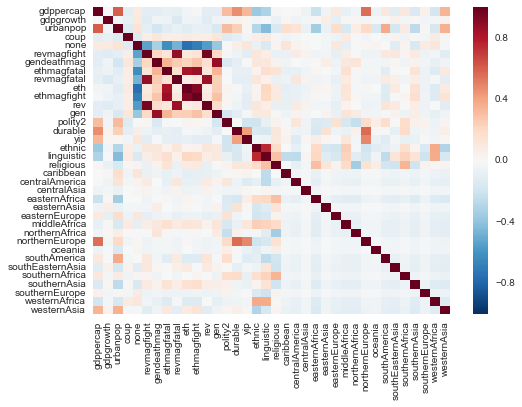

In [68]:
sns.heatmap(DF2.corr())

In [69]:
y = DF2["coup"]
X = DF2.drop(["coup"], axis=1)

In [70]:
from sklearn.cross_validation import KFold,cross_val_score,train_test_split,cross_val_predict
from sklearn.metrics import r2_score,accuracy_score,precision_score,recall_score
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Random Forest Classifier

In [72]:
# rf = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=100, oob_score = True) 

# rfparam_grid = { 
#                 'n_estimators': [25, 50,75,100,125,150,200],
#                 'criterion': ["gini", "entropy"],
#                 'max_features': [None, 'sqrt', 'log2'],
#                 'min_samples_split':[1,2,3,4,5,6]
#                }
    
# CV_rf = GridSearchCV(estimator=rf, param_grid=rfparam_grid, cv=5)
# CV_rf.fit(X_train, y_train)
# print CV_rf.best_params_

In [ ]:
cv = KFold(len(y_train), shuffle=False) 
print cv
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features="sqrt", max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=True, random_state=20, verbose=0, warm_start=False)
rfScore = cross_val_score(rf, X_train, y_train, cv=cv, n_jobs=-1)
print "Regular Decision Tree scores are:", rfScore
print "Regular Decision Tree average score is:", rfScore.mean()

sklearn.cross_validation.KFold(n=2097, n_folds=3, shuffle=False, random_state=None)
Regular Decision Tree scores are: [ 0.93991416  0.93562232  0.94849785]
Regular Decision Tree average score is: 0.941344778255


In [ ]:
rfModel = rf.fit(X_train, y_train)

In [ ]:
rfPredicted = rfModel.predict(X_test)
rfProbs = rfModel.predict_proba(X_test)

In [ ]:
rfPredictions = pd.DataFrame()
rfPredictions["Actual"] = y_test
rfPredictions["Predicted"] = rfPredicted
rfPredictions["ProbsPos"], rfPredictions["ProbsNeg"] = zip(*rfProbs)

In [ ]:
newList = []
newList2 = []
for i in np.arange(0,1,0.01):
    rfPredictions["ThreshPred"] = ([0 if x < i else 1 for x in rfPredictions['ProbsNeg']])
    newList.append(roc_auc_score(rfPredictions["Actual"], rfPredictions["ThreshPred"]))
    newList2.append(i)
d = zip(newList, newList2)
max(d)

In [ ]:
rfThreshold = max(d)[1]
rfPredictions["ThreshPred"] = ([0 if x < rfThreshold else 1 for x in rfPredictions['ProbsNeg']])

In [ ]:
print 'accuracy score:', accuracy_score(rfPredictions["Actual"], rfPredictions["ThreshPred"])
print 'ROC Score:', roc_auc_score(rfPredictions["Actual"], rfPredictions["ThreshPred"])

In [ ]:
print 'precision score:', precision_score(rfPredictions['Actual'],rfPredictions['ThreshPred'])
print 'recall score:', recall_score(rfPredictions['Actual'],rfPredictions['ThreshPred'])
print 'accuracy score:',accuracy_score(rfPredictions['Actual'],rfPredictions['ThreshPred'])

In [ ]:
print pd.crosstab(rfPredictions["Actual"], rfPredictions["ThreshPred"], rownames=["Actual"])

In [ ]:
rfPredictions["ThreshPred"].value_counts()

In [ ]:
rfPredictions["Actual"].value_counts()

In [ ]:
rfPredictions.head()

## AdaBoost Classifier

In [ ]:
# ab = AdaBoostClassifier() 

# abparam_grid = { 
#                 "n_estimators": [10,15,20,25,30],
#                 "learning_rate": [1.0,2.0,3.0,4.0,5.0,6.0],
#                 "algorithm": ["SAMME", "SAMME.R"]
#                }

# CV_ab= GridSearchCV(estimator=ab, param_grid=abparam_grid, cv=5)
# CV_ab.fit(X_train, y_train)
# print CV_ab.best_params_
# print CV_ab.best_estimator_

In [ ]:
cv = KFold(len(y_train), shuffle=False) 
print cv
ab = AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=2.0, n_estimators=15, random_state=20)

abScore = cross_val_score(ab, X_train, y_train, cv=cv,n_jobs=1)
print "Adaboost Decision Tree scores are:", abScore
print "Adaboost Decision Tree average score is:", abScore.mean()

In [ ]:
abModel = ab.fit(X_train, y_train)

In [ ]:
abPredicted = abModel.predict(X_test)
abProbs = abModel.predict_proba(X_test)

In [ ]:
abPredictions = pd.DataFrame()
abPredictions["Actual"] = y_test
abPredictions["Predicted"] = abPredicted
abPredictions["ProbsPos"], abPredictions["ProbsNeg"] = zip(*abProbs)

In [ ]:
newList3 = []
newList4 = []
for i in np.arange(0,1,0.01):
    abPredictions["ThreshPred"] = ([0 if x < i else 1 for x in abPredictions['ProbsNeg']])
    newList3.append(roc_auc_score(abPredictions["Actual"], abPredictions["ThreshPred"]))
    newList4.append(i)
e = zip(newList3, newList4)
max(e)

In [ ]:
abThreshold = max(e)[1]
abPredictions["ThreshPred"] = ([0 if x < abThreshold else 1 for x in abPredictions['ProbsNeg']])

In [ ]:
print accuracy_score(abPredictions["Actual"], abPredictions["ThreshPred"])
print roc_auc_score(abPredictions["Actual"], abPredictions["ThreshPred"])

In [ ]:
print 'precision score:', precision_score(abPredictions['Actual'],abPredictions['ThreshPred'])
print 'recall score:', recall_score(abPredictions['Actual'],abPredictions['ThreshPred'])
print 'accuracy score:',accuracy_score(abPredictions['Actual'],abPredictions['ThreshPred'])

In [ ]:
abPredictions.head()

In [ ]:
print pd.crosstab(abPredictions["Actual"], abPredictions["ThreshPred"], rownames=["Actual"])

In [ ]:
abPredictions["ThreshPred"].value_counts()

In [ ]:
abPredictions["Actual"].value_counts()

In [ ]:
rfPredictions.ThreshPred.head()

In [ ]:
# Compute ROC curve and ROC area for Random Forest
rffpr = dict()
rftpr = dict()
rfroc_auc = dict()
rffpr, rftpr, _ = roc_curve(y_test, rfPredictions.ProbsNeg)
rfroc_auc = auc(rffpr, rftpr)

# Compute ROC curve and ROC area for Adaboost
abfpr = dict()
abtpr = dict()
abroc_auc = dict()
abfpr, abtpr, _ = roc_curve(y_test, abPredictions.ProbsNeg)
abroc_auc = auc(abfpr, abtpr)


# Plot of a ROC curve 
plt.figure(figsize=(15,15))
plt.plot(rffpr,rftpr,label='Rf AUC = %0.2f' % rfroc_auc)
plt.plot(abfpr,abtpr,label='Ab AUC = %0.2f' % abroc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver Operating Characteristic\n', fontsize=30)
plt.legend(loc="lower right", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.show()

## Random Forest with Feature Selection - Robustness

In [ ]:
#averaginng feature importances across trees in random forest model
all(rf.feature_importances_ == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0))

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Feature Importances\n", fontsize = 30)
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90, fontsize = 20)
plt.xlim([-1, X_train.shape[1]])
plt.yticks(fontsize=20)

In [ ]:
X_new = DF2[["gdppercap", "urbanpop", "gdpgrowth", "durable", "yip",
            "polity2", "ethnic", "religious", "linguistic"]]

In [ ]:
X_newtrain, X_newtest, y_newtrain, y_newtest = train_test_split(X_new, y, test_size=0.3, random_state=0)

In [ ]:
# rf2 = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=100, oob_score = True) 

# rf2param_grid = { 
#                 'n_estimators': [50,75,100,125,150],
#                 'criterion': ["gini", "entropy"],
#                 'max_features': [None, 'sqrt', 'log2'],
#                 'min_samples_split':[1,2,3,4,5,6]
#                 }
    
# CV_rf2 = GridSearchCV(estimator=rf2, param_grid=rf2param_grid, cv=5)
# CV_rf2.fit(X_newtrain, y_newtrain)
# print CV_rf2.best_params_

In [ ]:
cv2 = KFold(len(y_newtrain), shuffle=False) 
print cv2
rf2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features="sqrt", max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=True, random_state=20, verbose=0, warm_start=False)
rfScore = cross_val_score(rf, X_train, y_train, cv=cv, n_jobs=-1)
print "Regular Decision Tree scores are:", rfScore
print "Regular Decision Tree average score is:", rfScore.mean()

In [ ]:
rf2Model = rf2.fit(X_newtrain, y_newtrain)

In [ ]:
rf2Predicted = rf2Model.predict(X_newtest)
rf2Probs = rf2Model.predict_proba(X_newtest)

In [ ]:
rf2Predictions = pd.DataFrame()
rf2Predictions["Actual"] = y_newtest
rf2Predictions["Predicted"] = rf2Predicted
rf2Predictions["ProbsPos"], rf2Predictions["ProbsNeg"] = zip(*rf2Probs)

In [ ]:
newList5 = []
newList6 = []
for i in np.arange(0,1,0.01):
    rf2Predictions["ThreshPred"] = ([0 if x < i else 1 for x in rf2Predictions['ProbsNeg']])
    newList5.append(roc_auc_score(rf2Predictions["Actual"], rf2Predictions["ThreshPred"]))
    newList6.append(i)
f = zip(newList5, newList6)
max(f)

In [ ]:
rf2Threshold = max(f)[1]
rf2Predictions["ThreshPred"] = [0 if x < rf2Threshold else 1 for x in rf2Predictions['ProbsNeg']]

In [ ]:
print pd.crosstab(rf2Predictions["Actual"], rf2Predictions["ThreshPred"], rownames=["Actual"])

In [ ]:
print accuracy_score(rf2Predictions["Actual"], rf2Predictions["ThreshPred"])
print roc_auc_score(rf2Predictions["Actual"], rf2Predictions["ThreshPred"])

In [ ]:
print 'precision score:', precision_score(rf2Predictions['Actual'],rf2Predictions['ThreshPred'])
print 'recall score:', recall_score(rf2Predictions['Actual'],rf2Predictions['ThreshPred'])
print 'accuracy score:',accuracy_score(rf2Predictions['Actual'],rf2Predictions['ThreshPred'])

In [ ]:
# Compute ROC curve and ROC area for Random Forest (with feature selection)
rffpr2 = dict()
rftpr2 = dict()
rfroc_auc2 = dict()
rffpr2, rftpr2, _ = roc_curve(y_newtest, rf2Predictions.ProbsNeg)
rfroc_auc2 = auc(rffpr2, rftpr2)

# Plot of a ROC curve 
plt.figure(figsize=(15,15))
plt.plot(rffpr2,rftpr2,label='Rf AUC = %0.2f' % rfroc_auc2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver Operating Characteristic\n', fontsize=30)
plt.legend(loc="lower right", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.show()

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [ ]:
DF2.head()

In [ ]:
#DF.to_csv("../assets/csv/final.csv")

In [ ]:
DF2.shape

In [ ]:
y1, X1 = dmatrices("coup ~ gdppercap + gdpgrowth + urbanpop + none + \
                    revmagfight + gendeathmag + ethmagfatal + revmagfatal + \
                    eth + ethmagfight + rev + gen + polity2 + durable + yip + \
                    ethnic + linguistic + religious + caribbean + centralAmerica + \
                    centralAsia + easternAfrica + easternAsia + easternEurope + \
                    middleAfrica + northernAfrica + northernEurope + oceania + southAmerica + \
                    southEasternAsia + southernAfrica + southernAsia + southernEurope + \
                    westernAfrica", DF2, return_type="dataframe")

In [ ]:
y1 = np.ravel(y1)

In [ ]:
lr = LogisticRegression()
lrModel = lr.fit(X1,y1)

In [ ]:
coeffName =  X1.columns.tolist()
coeff =  lrModel.coef_[0]
coeffs = pd.DataFrame(zip(coeffName, coeff), columns=["CoeffName", "Coeff"])
coeffs.head()

In [ ]:
X_norm =  StandardScaler().fit_transform(X1)

lrModel2 = lr.fit(X_norm, y1)
coeff2 = lrModel2.coef_[0]
coeffs2 = pd.DataFrame(zip(coeffName, coeff2), columns=["CoeffName", "Coeff"])
coeffs3 = coeffs2
coeffs3["Coeff"] = abs(coeffs3["Coeff"])
coeffs3.sort("Coeff", ascending = False, inplace=True)

In [ ]:
coeffs3.head(14)

In [ ]:
y2, X2 = dmatrices("coup ~ gdpgrowth + urbanpop + none + \
                     durable + polity22 + gdppercap + ethnic + \
                     linguistic +  + caribbean + easternAfrica + \
                     easternAsia + easternEurope + southernAfrica + \
                     southernAsia", DF2, return_type="dataframe")

In [ ]:
y2 = np.ravel(y2)

In [ ]:
lrModel2 = lr.fit(X2, y2)
# logit = sm.Logit(X2, y2)
# result = logit.fit()
# result.summary()
lrModel2.coef_

In [ ]:
coeffName2 =  X2.columns.tolist()
coeff2 =  np.exp(lrModel2.coef_[0])
coeffs2 = pd.DataFrame(zip(coeffName2, coeff2), columns=["CoeffName", "Coeff"])
coeffs2